# Local Interpretable Model Agnostic Explanations (LIME)

## License 

Copyright 2017 J. Patrick Hall, jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Local Interpretable Model Agnostic Explanations (LIME)
***

Based on: Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin. "Why should i trust you?: Explaining the predictions of any classifier." In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pp. 1135-1144. ACM, 2016.

http://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf

**Instead of perturbing a sample of interest to create a local region in which to fit a linear model, these examples use a practical sample, say all one story homes, from the data to create an approximately local region in which to fit a linear model.**

#### Python imports

In [1]:
# h2o Python API with specific classes
import h2o 
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

import operator

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling

# display plots in notebook
%matplotlib inline

#### Start h2o

In [2]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp4_dl3h6i
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp4_dl3h6i/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp4_dl3h6i/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.14.0.2
H2O cluster version age:,1 month and 10 days
H2O cluster name:,H2O_from_python_phall_h5tw7t
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **LIMIT_BAL**: Amount of given credit (NT dollar)
* **SEX**: 1 = male; 2 = female
* **EDUCATION**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **MARRIAGE**: 1 = married; 2 = single; 3 = others
* **AGE**: Age in years 
* **PAY_0, PAY_2 - PAY_6**: History of past payment; PAY_0 = the repayment status in September, 2005; PAY_2 = the repayment status in August, 2005; ...; PAY_6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **BILL_AMT1 - BILL_AMT6**: Amount of bill statement (NT dollar). BILL_AMNT1 = amount of bill statement in September, 2005; BILL_AMT2 = amount of bill statement in August, 2005; ...; BILL_AMT6 = amount of bill statement in April, 2005. 
* **PAY_AMT1 - PAY_AMT6**: Amount of previous payment (NT dollar). PAY_AMT1 = amount paid in September, 2005; PAY_AMT2 = amount paid in August, 2005; ...; PAY_AMT6 = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005.

Because H2O accepts both numeric and character inputs, some variables will be recoded into more transparent character values.

#### Download data and clean

In [3]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

In [4]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Helper function for recoding values in the UCI credict card default data

In [5]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        Pandas DataFrame with recoded values.
        
    """
    
    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}
    
    # recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in  frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            
                
    return frame

data = recode_cc_data(data)

#### Convert from Pandas DataFrame to H2OFrame

In [6]:
data = h2o.H2OFrame(data)    # convert 
data[y] = data[y].asfactor() # ensure target is handled as a categorical variable

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Display descriptive statistics

In [7]:
data.describe()

Rows:30000
Cols:25




,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
type,int,int,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,1.0,10000.0,,,,21.0,,,,,,,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,
mean,15000.5,167484.32266666688,,,,35.48549999999994,,,,,,,51223.33090000009,49179.07516666668,47013.15479999971,43262.9489666666,40311.40096666653,38871.76039999991,5663.580500000014,5921.16350000001,5225.681500000005,4826.076866666661,4799.387633333302,5215.502566666664,
maxs,30000.0,1000000.0,,,,79.0,,,,,,,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,
sigma,8660.398374208891,129747.66156720225,,,,9.21790406809016,,,,,,,73635.86057552959,71173.76878252836,69349.38742703681,64332.85613391641,60797.1557702648,59554.10753674574,16563.280354025763,23040.870402057226,17606.961469803115,15666.159744031993,15278.305679144793,17777.465775435332,
zeros,0,0,,,,0,,,,,,,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,20000.0,female,university,married,24.0,2 month delay,2 month delay,pay duly,pay duly,no consumption,no consumption,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2.0,120000.0,female,university,single,26.0,pay duly,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,2 month delay,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3.0,90000.0,female,university,single,34.0,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


## 2. Train an H2O GBM classifier

In [8]:
# split into training and validation
train, test = data.split_frame([0.7], seed=12345)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21060, columns = 25
Test data rows = 8940, columns = 25


In [9]:
# initialize GBM model
model = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                     max_depth=4,           # trees can have maximum depth of 4
                                     sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.9,   # use 90% of variables in each iteration (tree)
                                     balance_classes=True,  # sample to balance 0/1 distribution of target - helps LOCO
                                     stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                     seed=12345)            # random seed for reproducibility

# train a GBM model
model.train(y=y, x=X, training_frame=train, validation_frame=test)

# print AUC
print('GBM Test AUC = %.2f' % model.auc(valid=True))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.78


## 3. Use LIME to generate descriptions for a local region with a perturbed sample

In [10]:
row = test[test['ID'] == 22760]
row

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
22760,460000,female,graduate school,married,40,3 month delay,2 month delay,2 month delay,3 month delay,3 month delay,3 month delay,2650,2650,2650,2650,2650,2650,0,0,0,0,0,200,1


In [11]:
def generate_local_sample(row, frame, X, N=1000):
    
    """ Generates a perturbed sample around a row of interest.
    
    Args:
        row: Row of H2OFrame to be explained.
        frame: H2OFrame in which row is stored.
        X: List of model input variables.
        N: Number of samples to generate.
    
    Returns:
        Pandas DataFrame containing perturbed sample.
    
    """
    
    # random seed for reproducibility
    np.random.seed(12345)
    
    # initialize Pandas DataFrame
    sample_frame = pd.DataFrame(data=np.zeros(shape=(N, len(X))), columns=X)
    
    # generate column vectors of 
    # randomly drawn levels for categorical variables
    # normally distributed numeric values around mean of column for numeric variables
    for key, val in frame[X].types.items():
        if val == 'enum': # 'enum' == categorical
            draw = np.random.choice(frame[key].levels()[0], size=(1, N))[0]
        else:
            loc = row[key][0, 0]
            sd = frame[key].sd()
            draw = np.random.normal(loc, sd, (N, 1))
            sample_frame[key] = draw
        
        sample_frame[key] = draw
        
    return sample_frame

# run and display results
perturbed_sample = generate_local_sample(row, test, X)
perturbed_sample.head(n=3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,500626.953318,female,other,married,46.021815,4 month delay,1 month delay,no consumption,3 month delay,6 month delay,...,139172.014974,-14006.337808,-17775.467837,-13835.889113,1642.679179,-15473.415631,4339.221830,31431.807700,21092.134460,14783.813391
1,372139.832563,female,graduate school,married,50.893430,no consumption,5 month delay,6 month delay,6 month delay,4 month delay,...,10174.221507,28085.770688,-105519.269815,20220.656926,1692.988455,27906.099962,24829.023071,-9781.319575,-9791.678845,14623.471753
2,423561.903453,male,graduate school,divorced,35.716763,3 month delay,5 month delay,no consumption,2 month delay,3 month delay,...,-23866.193844,11602.421915,2294.675217,-117530.407104,-1570.978207,-395.717459,16265.566277,984.207686,-39235.089067,12550.174285


#### Calculate distance between row of interest and perturbed sample

In [12]:
# one-hot encoding for calculating Euclidian distance
row_df = test[test['ID'] == 22760].as_data_frame()
row_dummies = pd.concat([row_df.drop(['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
                                   'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT_NEXT_MONTH'], axis=1),
                        pd.get_dummies(row_df[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
                                            'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']])], 
                        axis=1)

# convert to H2OFrame
row_dummies = h2o.H2OFrame(row_dummies)
row_dummies

Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_female,EDUCATION_graduate school,MARRIAGE_married,PAY_0_3 month delay,PAY_2_2 month delay,PAY_3_2 month delay,PAY_4_3 month delay,PAY_5_3 month delay,PAY_6_3 month delay
460000,40,2650,2650,2650,2650,2650,2650,0,0,0,0,0,200,1,1,1,1,1,1,1,1,1


In [13]:
# one-hot encoding for calculating Euclidian distance
perturbed_sample_dummies = pd.concat([perturbed_sample.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
                                                             'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'], axis=1),
                                      pd.get_dummies(perturbed_sample[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
                                                                       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']])],
                                     axis=1)

# convert to H2OFrame
perturbed_sample_dummies = h2o.H2OFrame(perturbed_sample_dummies[row_dummies.columns])
perturbed_sample_dummies.head(rows=3)

Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_female,EDUCATION_graduate school,MARRIAGE_married,PAY_0_3 month delay,PAY_2_2 month delay,PAY_3_2 month delay,PAY_4_3 month delay,PAY_5_3 month delay,PAY_6_3 month delay
500627,46.0218,23281.1,1626.1,139172,-14006.3,-17775.5,-13835.9,1642.68,-15473.4,4339.22,31431.8,21092.1,14783.8,1,0,1,0,0,0,1,0,1
372140,50.8934,165473,153468,10174.2,28085.8,-105519,20220.7,1692.99,27906.1,24829,-9781.32,-9791.68,14623.5,1,1,1,0,0,0,0,0,0
423562,35.7168,-6384.89,-104744,-23866.2,11602.4,2294.68,-117530,-1570.98,-395.717,16265.6,984.208,-39235.1,12550.2,0,1,0,1,0,0,0,1,0


In [14]:
# calculate distance
distance = row_dummies.distance(perturbed_sample_dummies, measure='l2').transpose()
distance.columns = ['distance']          # rename 
distance = distance.scale(center=False)  # scale, all positive
distance = distance.max() - distance     # lower distances, higher weight in LIME
distance.head(rows=3)

distance
7.39422
5.73597
7.16777


#### Bind distance weights onto perturbed sample

In [15]:
perturbed_sample = h2o.H2OFrame(perturbed_sample).cbind(distance)
perturbed_sample.head(rows=3)

Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,distance
500627,female,other,married,46.0218,4 month delay,1 month delay,no consumption,3 month delay,6 month delay,3 month delay,23281.1,1626.1,139172,-14006.3,-17775.5,-13835.9,1642.68,-15473.4,4339.22,31431.8,21092.1,14783.8,7.39422
372140,female,graduate school,married,50.8934,no consumption,5 month delay,6 month delay,6 month delay,4 month delay,4 month delay,165473,153468,10174.2,28085.8,-105519,20220.7,1692.99,27906.1,24829,-9781.32,-9791.68,14623.5,5.73597
423562,male,graduate school,divorced,35.7168,3 month delay,5 month delay,no consumption,2 month delay,3 month delay,2 month delay,-6384.89,-104744,-23866.2,11602.4,2294.68,-117530,-1570.98,-395.717,16265.6,984.208,-39235.1,12550.2,7.16777


#### Bind model predictions onto perturbed sample

In [16]:
preds1 = model.predict(perturbed_sample).drop(['predict', 'p0'])
preds1.columns = ['p_DEFAULT_NEXT_MONTH']
perturbed_sample = perturbed_sample.cbind(preds1)
perturbed_sample.head(rows=3)

gbm prediction progress: |████████████████████████████████████████████████| 100%


LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,distance,p_DEFAULT_NEXT_MONTH
500627,female,other,married,46.0218,4 month delay,1 month delay,no consumption,3 month delay,6 month delay,3 month delay,23281.1,1626.1,139172,-14006.3,-17775.5,-13835.9,1642.68,-15473.4,4339.22,31431.8,21092.1,14783.8,7.39422,0.0250431
372140,female,graduate school,married,50.8934,no consumption,5 month delay,6 month delay,6 month delay,4 month delay,4 month delay,165473,153468,10174.2,28085.8,-105519,20220.7,1692.99,27906.1,24829,-9781.32,-9791.68,14623.5,5.73597,0.060543
423562,male,graduate school,divorced,35.7168,3 month delay,5 month delay,no consumption,2 month delay,3 month delay,2 month delay,-6384.89,-104744,-23866.2,11602.4,2294.68,-117530,-1570.98,-395.717,16265.6,984.208,-39235.1,12550.2,7.16777,0.616653


#### Train penalized linear model in local region 
* Check R<sup>2</sup> to ensure surrogate model is a good fit for predictions
* Use ranked predictions plot to ensure surrogate model is a good fit for predictions
* Use trained GLM and coefficients to understand local region of response function

In [17]:
# initialize
local_glm1 = H2OGeneralizedLinearEstimator(lambda_search=True, 
                                           weights_column='distance')
# train 
local_glm1.train(x=X, y='p_DEFAULT_NEXT_MONTH', training_frame=perturbed_sample)

# coefs
print('\nLocal GLM Coefficients:')
for c_name, c_val in sorted(local_glm1.coef().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))
        
# r2
print('\nLocal GLM R-square:\n%.2f' % local_glm1.r2())

glm Model Build progress: |███████████████████████████████████████████████| 100%

Local GLM Coefficients:
EDUCATION.other:          -0.1793255253670767
MARRIAGE.other:           -0.13321307788931702
PAY_2.1 month delay:      -0.11240242717373701
PAY_0.use of revolving credit: -0.10873247720859473
PAY_0.pay duly:           -0.09961438038496874
PAY_0.no consumption:     -0.09759895262214492
PAY_2.8 month delay:      -0.08232720778289826
PAY_2.pay duly:           -0.07817364269285788
PAY_2.no consumption:     -0.06243470712786671
PAY_0.1 month delay:      -0.05217891922373698
PAY_5.use of revolving credit: -0.04355698988136915
PAY_6.6 month delay:      -0.029082582182110798
PAY_3.pay duly:           -0.026696639115183222
PAY_4.7 month delay:      -0.023727338675133304
PAY_5.5 month delay:      -0.021423026426095514
PAY_4.6 month delay:      -0.02142063231312331
PAY_5.no consumption:     -0.018531833500900805
PAY_3.5 month delay:      -0.01825694772834637
PAY_0.5 month delay:      -0.01622

In [18]:
type(row)

h2o.frame.H2OFrame

## 4. Generate reason codes with LIME based on a perturbed sample

In [19]:
def plot_local_contrib(row, model, frame, X): 

    """ Plots reason codes in a bar chart. 
    
    Args:
    
        row: Row of H2OFrame to be explained.
        frame: H2OFrame in which row is stored.
        model: H2O linear model used for generating reason codes.
        X: List of model input variables.
    
    """
    
    # initialize Pandas DataFrame to store results
    local_contrib_frame = pd.DataFrame(columns=['Name', 'Local Contribution', 'Sign'])
    
    # multiply values in row by local glm coefficients    
    for key, val in row[X].types.items():
        contrib = 0
        name = ''
        if val == 'enum':
                level = row[key][0, 0]
                name = '.'.join([str(key), str(level)])
                if name in model.coef():
                    contrib = model.coef()[name]
        else:
            name = key
            if name in model.coef():
                contrib = row[name][0, 0]*model.coef()[name]
        
        # save only non-zero values
        if contrib != 0.0:
            local_contrib_frame = local_contrib_frame.append({'Name': name,
                                                              'Local Contribution': contrib,
                                                              'Sign': contrib > 0}, 
                                                             ignore_index=True)  
    # plot
    _ = local_contrib_frame.plot(x='Name',
                                 y='Local Contribution',
                                 kind='bar', 
                                 title='Reason Codes', 
                                 color=''.join(local_contrib_frame.Sign.map({True:'b', False:'r'}).values), 
                                 legend=False) 
    

#### Display reason codes

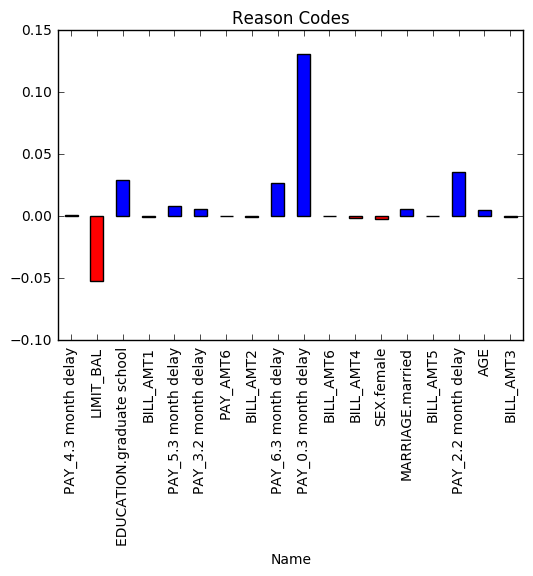

In [20]:
plot_local_contrib(row, local_glm1, test, X)

## 5. Use LIME to generate descriptions for a local region with a practical sample

#### Create a local region based on values of PAY_0

In [21]:
preds2 = model.predict(test).drop(['predict', 'p0'])
preds2.columns = ['p_DEFAULT_NEXT_MONTH']
practical_sample = test.cbind(preds2)
practical_sample = practical_sample[practical_sample['SEX'] == 'female']
practical_sample.describe()

gbm prediction progress: |████████████████████████████████████████████████| 100%
Rows:5463
Cols:26




,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
type,int,int,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,int,int,enum,real
mins,4.0,10000.0,,,,21.0,,,,,,,-154973.0,-26214.0,-15910.0,-15910.0,-28335.0,-209051.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.004584051026802937
mean,15040.13197876627,171173.34797730207,,,,34.839648544755605,,,,,,,48748.91817682587,47271.87717371407,45427.75928976755,42105.330770638844,39677.749222039194,38118.17847336625,5799.562145341385,5506.4825187625775,5004.218927329306,4863.755811824999,4835.199707120634,5078.960278235403,,0.20188681798164845
maxs,29179.0,780000.0,,,,75.0,,,,,,,626648.0,586825.0,577957.0,563543.0,530672.0,511905.0,493358.0,1227082.0,371718.0,400046.0,388071.0,443001.0,,0.8908795141080315
sigma,8451.59661253189,125261.33709325126,,,,9.015564190856791,,,,,,,69867.88964635596,67994.2813521727,65972.07593572335,61876.24000620019,59348.872367527256,57801.079841826264,17535.230995305028,21340.42870233809,14736.960796122034,15612.827746084311,14888.07545565182,17850.739397457837,,0.1914046320657202
zeros,0,0,,,,0,,,,,,,403,510,557,627,662,732,990,970,1083,1128,1178,1297,,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,4.0,50000.0,female,university,married,37.0,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,0.1438076658666565
1,8.0,100000.0,female,university,single,23.0,use of revolving credit,pay duly,pay duly,use of revolving credit,use of revolving credit,pay duly,11876.0,380.0,601.0,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0,0.11550598047910923
2,16.0,50000.0,female,high school,divorced,23.0,1 month delay,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,50614.0,29173.0,28116.0,28771.0,29531.0,30211.0,0.0,1500.0,1100.0,1200.0,1300.0,1100.0,0,0.3652491527338868


#### Train penalized linear model in local region 
* Check R<sup>2</sup> to ensure surrogate model is a good fit for predictions
* Use ranked predictions plot to ensure surrogate model is a good fit for predictions
* Use trained GLM and coefficients to understand local region of response function

In [22]:
# initialize
local_glm2 = H2OGeneralizedLinearEstimator(lambda_search=True)

# train 
local_glm2.train(x=X, y='p_DEFAULT_NEXT_MONTH', training_frame=practical_sample)

# coefs
print('\nLocal GLM Coefficients:')
for c_name, c_val in sorted(local_glm2.coef().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))
        
# r2
print('\nLocal GLM R-square:\n%.2f' % local_glm2.r2())

glm Model Build progress: |███████████████████████████████████████████████| 100%

Local GLM Coefficients:
PAY_2.1 month delay:      -0.19456955299104287
PAY_0.use of revolving credit: -0.1635697771516117
PAY_0.no consumption:     -0.13144423208435868
PAY_4.5 month delay:      -0.11983188393081368
MARRIAGE.other:           -0.09534639505407974
EDUCATION.other:          -0.09486663698508511
PAY_0.pay duly:           -0.0760167837259141
PAY_5.4 month delay:      -0.06123205645050032
PAY_4.pay duly:           -0.04857241595473708
PAY_3.5 month delay:      -0.03870035194869233
PAY_4.no consumption:     -0.03748052132906239
PAY_4.use of revolving credit: -0.03740951891789573
PAY_3.pay duly:           -0.03603524089046462
PAY_6.use of revolving credit: -0.03380137382285508
PAY_3.no consumption:     -0.029601222575892257
PAY_2.pay duly:           -0.02898729206564798
PAY_3.4 month delay:      -0.02408862698025022
PAY_2.4 month delay:      -0.02297065240340565
PAY_5.pay duly:           -0.02253

## 6. Generate a ranked predictions plot to assess validity of local explanatory model

glm prediction progress: |████████████████████████████████████████████████| 100%


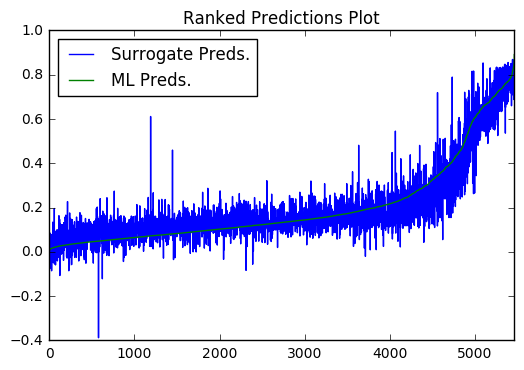

In [23]:
# ranked predictions plot
pred_frame = local_glm2.predict(practical_sample).cbind(practical_sample)\
                       .as_data_frame()[['predict', 'p_DEFAULT_NEXT_MONTH']]

pred_frame.columns = ['Surrogate Preds.', 'ML Preds.']
pred_frame.sort_values(by='ML Preds.', inplace=True)
pred_frame.reset_index(inplace=True, drop=True)
_ = pred_frame.plot(title='Ranked Predictions Plot')

A ranked predictions plot is a way to visually check whether the surrogate model is a good fit for the complex model. The y-axis is the numeric prediction of both models for a given point. The x-axis is the rank of a point when the predictions are sorted by their GBM prediction, from lowest on the left to highest on the right. When both sets of predictions are aligned, as they are above, this a good indication that the linear model fits the complex, nonlinear GBM well in the approximately local region.

Both the R<sup>2</sup> and ranked predictions plot show the linear model is a good fit in the practical, approximately local sample. This means the regression coefficients are likely a very accurate representation of the behavior of the nonlinear model in this region.

## 7. Generate reason codes using a practical sample

#### Create explanations (or 'reason codes') for a row in the local set
The local glm coefficient multiplied by the value in a specific row are estimates of how much each variable contributed to each prediction decision. These values can tell you how a variable and it's values were weighted in any given decision by the model. These values are crucially important for machine learning interpretability and are often to referred to "local feature importance", "reason codes", or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders must provide reasons for turning down a credit application, even for automated decisions. Reason codes can be easily extracted from LIME local feature importance values, by simply ranking the variables that played the largest role in any given decision.

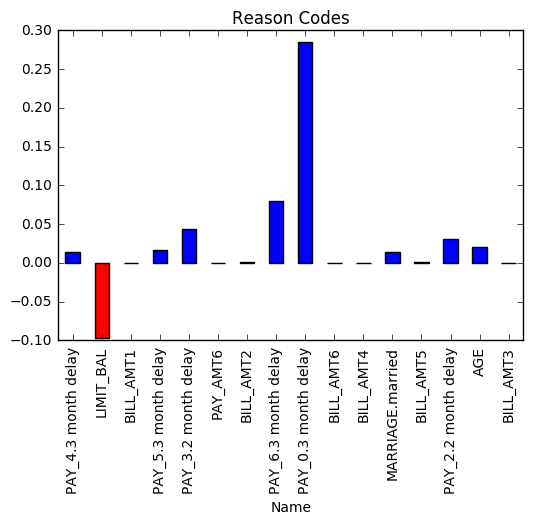

In [24]:
plot_local_contrib(row, local_glm2, practical_sample, X)                                                             

#### Shutdown H2O

In [25]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_a6b0 closed.
